# **Visualize NFS Data**

Visualize dynamic antenna data from Python-based near field scanning system.

## Load libraries and functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import scipy.constants
import scipy.io

C = scipy.constants.c

def spherical_to_cartesian_vector(vec, theta_list, phi_list):
    # vec n X 3, theta_list n X 1, phi_list n X 1
    if np.isscalar(theta_list):
        n = 1
    else:
        n = phi_list.size
    T = np.reshape(np.column_stack((
        np.sin(theta_list)*np.cos(phi_list), 
        np.cos(theta_list)*np.cos(phi_list),
        -np.sin(phi_list),
        np.sin(theta_list)*np.sin(phi_list),
        np.cos(theta_list)*np.sin(phi_list),
        np.cos(phi_list),
        np.cos(theta_list),
        -np.sin(theta_list),
        np.zeros(n))),
              (n, 3, 3))
    return np.matmul(T, vec[:,:,None])[:,:,0]

def prop_from_magnetic_currents(K_m, r_vec, k, N):
    x = np.unique(r_vec[:,0])
    y = np.unique(r_vec[:,1])
    
    K_m_array = np.reshape(K_m, (x.size, y.size, 3))
    Theta_far, Phi_far = np.meshgrid(
        np.arange(0, np.pi/2, np.pi/N),
        np.arange(0, 2*np.pi, np.pi/N),
        indexing='ij')    
    theta_list = Theta_far.reshape(-1)
    phi_list = Phi_far.reshape(-1)
    
    r_hat = spherical_to_cartesian_vector(np.transpose(np.array([1, 0, 0])[:,None]),
                                         Theta_far.reshape(-1), 
                                         Phi_far.reshape(-1))
    k_far_vec = k * r_hat
    
    L_theta = np.empty((Theta_far.size), dtype=np.complex64)
    L_phi = np.empty((Theta_far.size), dtype=np.complex64)
    for i in range(Theta_far.size):
        integrand_theta = ((K_m_array[:,:,0]*np.cos(theta_list[i])*np.cos(phi_list[i]) + 
                           K_m_array[:,:,1]*np.cos(theta_list[i])*np.sin(phi_list[i]) -
                           K_m_array[:,:,2]*np.sin(theta_list[i])) *
                           np.reshape(np.exp(1j*np.sum(k_far_vec[i] * r_vec, 1)), (x.size, y.size)))
        integrand_phi = ((-K_m_array[:,:,0]*np.sin(phi_list[i]) + 
                           K_m_array[:,:,1]*np.cos(phi_list[i])) *
                           np.reshape(np.exp(1j*np.sum(k_far_vec[i] * r_vec, 1)), (x.size, y.size)))

        L_theta[i] = np.trapz(np.trapz(integrand_theta, x, axis=0), y, axis=0)
        L_phi[i] = np.trapz(np.trapz(integrand_phi, x, axis=0), y, axis=0)
        
    E = np.transpose(np.array([
        np.zeros(L_theta.shape), -L_phi, L_theta]))
        
    return Theta_far, Phi_far, E

def fft_prop_from_magnetic_currents(K_m, r_vec, k, N):
    x = np.unique(r_vec[:,0])
    y = np.unique(r_vec[:,1])
    
    K_m_reshape = np.transpose(np.reshape(K_m, (y.size, x.size, 3)), (1, 0, 2))
    K_m_pad = np.pad(K_m_reshape, ((N, N), (N, N), (0, 0)), 'constant')

    K_m_ft = np.fft.fftshift(np.fft.ifftn(np.fft.ifftshift(
            K_m_pad, axes=(0,1)), s=None, axes=(0,1)), axes=(0,1))
    delta_x = np.abs(x[1]-x[0])
    delta_y = np.abs(y[1]-y[0])
    kx = np.linspace(-np.pi/delta_x, np.pi/delta_x, K_m_ft.shape[0]).astype(np.complex64)
    ky = np.linspace(-np.pi/delta_y, np.pi/delta_y, K_m_ft.shape[1]).astype(np.complex64)
    kx_nonzeros = np.where(np.abs(kx)<k)
    ky_nonzeros = np.where(np.abs(ky)<k)
    Kx_nonzeros, Ky_nonzeros = np.meshgrid(kx_nonzeros, ky_nonzeros, indexing='ij')
    kx = kx[kx_nonzeros]
    ky = ky[ky_nonzeros]
    Kx, Ky = np.meshgrid(kx, ky, indexing='ij')
    Kz = np.sqrt(k**2 - Kx**2 - Ky**2)

    Theta_prop = np.arccos(np.real(Kz)/k)
    Phi_prop = np.arctan2(np.real(Ky), np.real(Kx))

    f_phi = ( np.cos(Theta_prop) * np.cos(Phi_prop) * K_m_ft[Kx_nonzeros,Ky_nonzeros,0] + 
             np.cos(Theta_prop) * np.sin(Phi_prop) * K_m_ft[Kx_nonzeros, Ky_nonzeros,1] )
    f_theta = ( -np.sin(Phi_prop) * K_m_ft[Kx_nonzeros, Ky_nonzeros,0] + 
               np.cos(Phi_prop) * K_m_ft[Kx_nonzeros, Ky_nonzeros,1] )

    E = np.transpose(np.array([
        np.reshape(np.zeros(f_theta.shape), -1), np.reshape(-f_phi, -1), np.reshape(f_theta, -1)]))

    return Theta_prop, Phi_prop, E

## Load data

In [2]:
filepath = '../Data/Mike_Antenna/Near field Scans/'
filename_X = 'Mike_Antenna_co_pol_30-Oct-2021_9_0.mat'      # file corresponding to NFS with probe oriented in horizontal direction
filename_Y = 'Mike_Antenna_cross_pol_02-Nov-2021_10_32.mat'  # file corresponding to NFS with probe oriented in vertical direction

data = scipy.io.loadmat(filepath + filename_X)
f = data['f'][0,:]
X = data['X'].reshape(-1)/1000
Y = data['Y'].reshape(-1)/1000
r_vec = np.stack((X, Y, np.zeros(X.shape)), axis=1)
nfs_data_X = data['measurements']
n_ts = nfs_data_X.shape[3]
nfs_data_X = np.reshape(nfs_data_X, (X.size, f.size, n_ts))

if filename_Y is not None:
    data = scipy.io.loadmat(filepath + filename_Y)
    nfs_data_Y = data['measurements']
    nfs_data_Y = np.reshape(nfs_data_Y, (X.size, f.size, n_ts))
    Npolarizations = 2
else:
    nfs_data_Y = np.zeros(nfs_data_X.shape, dtype=np.complex64)     # if we only scanned the horizontal polarization, set the vertical component to zero
    Npolarizations = 1
    
x = np.unique(X)
y = np.unique(Y)

FileNotFoundError: [Errno 2] No such file or directory: '../Data/Mike_Antenna/Near field Scans/Mike_Antenna_co_pol_30-Oct-2021_9_0.mat'

## Select tuning state & frequency, and plot one tuning state

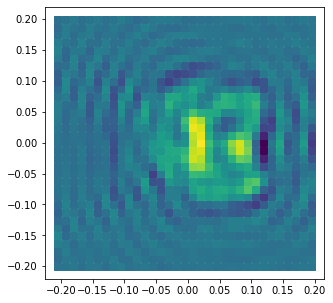

In [ ]:
ts_indx = 0
f0 = 10E9
f_indx = np.argmin(np.abs(f - f0))
k = 2*np.pi*f/C

fig = plt.figure(figsize=(5,5))
plt.scatter(X, Y, 50, np.real(nfs_data_X[:,f_indx,ts_indx]), 's')
plt.show()

## Propagate

In [ ]:
n_hat = np.transpose(np.array([0, 0, 1])[:,None])       # specify antenna orientation
E_nf = np.stack((nfs_data_X[:,f_indx,ts_indx],          # stack NFS data into E-field vector
              nfs_data_Y[:,f_indx,ts_indx],
              np.zeros(nfs_data_X[:,f_indx, ts_indx].shape)), axis=1)
K_m = -np.cross(n_hat, E_nf, axisa=1, axisb=1, axisc=1)     # define magnetic current from surface equivalence relationship

N = 180
Theta_far, Phi_far, E = prop_from_magnetic_currents(K_m, r_vec, k[f_indx], N)   # propagate magnetic surface currents to far field
theta_far = np.unique(Theta_far)
phi_far = np.unique(Phi_far)

E_int = np.abs(np.sum(E * np.conjugate(E), 1)).astype(np.float32)       # compute far-field radiation intensity
E_plot = np.reshape(E_int, Theta_far.shape)

P_tot = np.trapz(np.trapz(                              # trapezoidal numerical integration for total power evaluation
            E_plot * np.sin(Theta_far),
            theta_far, axis=0), phi_far, axis=0)
directivity = 10*np.log10(4*np.pi*np.amax(E_int)/P_tot)     # compute directivity

print('Directivity:', directivity)
print('Peak Signal:', np.amax(E_int))

Directivity: 19.275906501042538
Peak Signal: 1.7457788e-07


## Plot

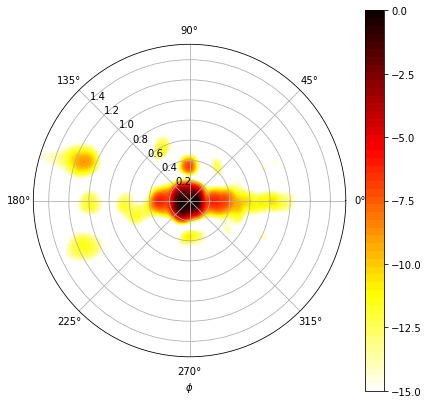

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'), figsize=(7,7))
cs = ax.contourf(Phi_far, Theta_far, 10*np.log10(E_plot/np.amax(E_plot)), 
            np.linspace(-15, 0, 50), 
            cmap=plt.cm.hot_r)
ax.grid(True)
ax.set_rlabel_position(135)
fig.colorbar(cs, ticks=np.linspace(-15, 0, 7))
plt.xlabel('$\phi$')
#plt.ylabel(r'$\theta$')
plt.show()

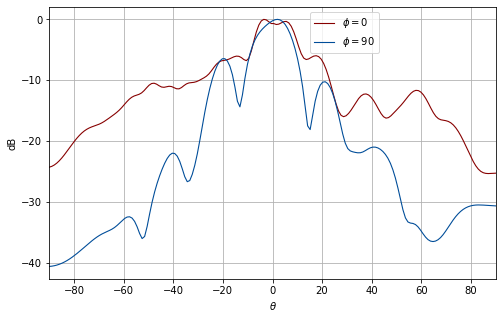

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

theta_plot0 = np.concatenate((np.flip(E_plot[1:,0][:,None]), E_plot[:,180][:,None]))
theta_plot90 = np.concatenate((np.flip(E_plot[1:,90][:,None]), E_plot[:,270][:,None]))

ax.plot(np.degrees(np.linspace(-np.pi/2, np.pi/2, theta_plot0.size)), 
        10*np.log10(theta_plot0/np.amax(theta_plot0)), 
        label=r'$\phi=0$',
        color=(0.53,0.0,0.0),
         linewidth=1.1)
ax.plot(np.degrees(np.linspace(-np.pi/2, np.pi/2, theta_plot90.size)), 
        10*np.log10(theta_plot90/np.amax(theta_plot90)), 
        label=r'$\phi=90$',
        color=(0,.3,.6),
         linewidth=1.1)
ax.set_ylabel('dB')
ax.set_xlabel(r'$\theta$')
ax.set_yticks([-40, -30, -20, -10, 0])
ax.set_xlim(-90, 90)
ax.legend(frameon=True, bbox_to_anchor=(0.75, 1))
ax.grid(visible=True, which='major')
plt.show()

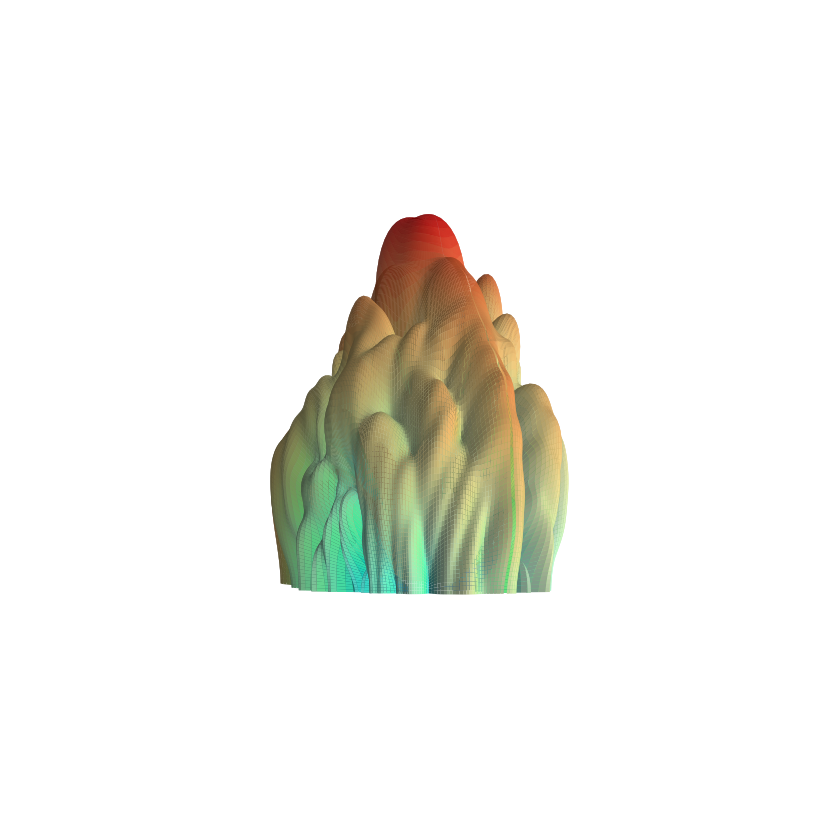

In [ ]:
from matplotlib.colors import LightSource
from matplotlib import cm

plot_exponent = 1

R = 10*np.log10(E_plot/np.amax(E_plot))
R = (R-np.amin(R))**plot_exponent
R_max = np.amax(R)
X_3D = R * np.sin(Theta_far) * np.cos(Phi_far)
Y_3D = R * np.sin(Theta_far) * np.sin(Phi_far)
Z_3D = R * np.cos(Theta_far)
color_vals = R

# my_col = plt.cm.rainbow(color_vals)
ls = LightSource(270, 45)
my_col = ls.shade(color_vals, cmap=cm.rainbow, vert_exag=0.5, blend_mode='soft')

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.plot_surface(
    X_3D, Y_3D, Z_3D, linewidth=0, facecolors=my_col,
    rstride=1, cstride=1, shade=True, alpha=1)
# fig.colorbar(plot, ax=ax)
ax.view_init(elev=0, azim=-30)
ax.set_xlim(-R_max, R_max)
ax.set_ylim(-R_max, R_max)
ax.set_zlim(0, R_max)
ax.grid(False)
plt.axis('off')
plt.show()